## Exponential Smoothing

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### Set Up Data

In [3]:
#parse datetime with weird timezone format
def parse_datetime_with_timezone(dt_str):
    datetime_str = dt_str[:-3] + dt_str[-2:]
    return pd.to_datetime(datetime_str, utc=True, format="%Y-%m-%d %H:%M:%S%z")

# TODO RE-Write without using "date_parser"
df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')

# Make sure this is the right timezone 
df.index = df.index.tz_convert('America/New_York')

#Set the frequency
#we need to do this before using in STL 
df= df.asfreq(freq='h')

/var/folders/n9/fmlq1lnj2f7d297hfrdwxdb80000gn/T/ipykernel_50735/1879699630.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')


In [4]:
df.drop(columns=["KCPLIATANUNIAT2","KCPLLACYGNEUNLAC2","SECI.KCPS.CIMARRON", "WR.LEC.4", "WR.JEC.2", "WR.JEC.3", "SECI.KCPS.CIMARRON"], inplace=True)

In [5]:
cimarron=df[["SECI_CIMARRON"]]

[Cross Validation StatsModels](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_forecasting.html#Cross-validation)  
[Stats Model Exponential Smoothin](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#)

### Simple Exponential Smoothing

Fit three models $\alpha = 0.2$,$\alpha=0.6$,and for the third is $\alpha$ by statsmodel to the optimized value

In [32]:
fit1 = SimpleExpSmoothing(cimarron, initialization_method = "heuristic").fit(smoothing_level=0.2, optimized=False)
fit2 = SimpleExpSmoothing(cimarron, initialization_method = "heuristic").fit(smoothing_level=0.6, optimized=False)
fit3 = SimpleExpSmoothing(cimarron, initialization_method = "estimated").fit()

fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

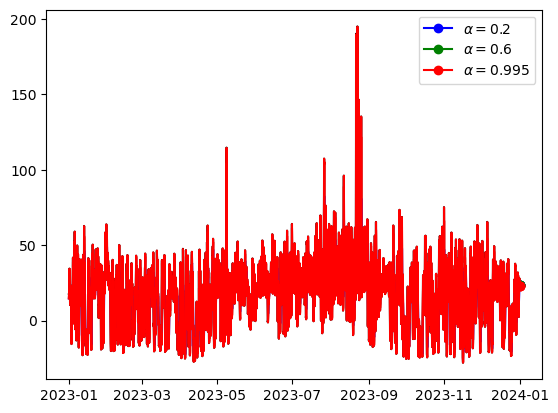

In [33]:
plt.figure()
plt.plot(cimarron, color = "black")
plt.plot(fit1.fittedvalues, color="blue")
(line1, )=plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2, )=plt.plot(fcast2, marker="o", color="green")
plt.plot(fit3.fittedvalues, color="red")
(line3, )=plt.plot(fcast3, marker="o", color="red")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

optimized $\alpha$ is nearly 1, so the most recent observations have the biggest weight

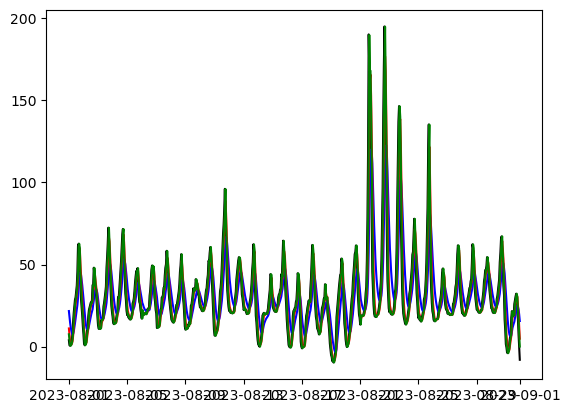

In [34]:
plt.figure()
plt.plot(cimarron.loc["2023-08"], color = "black")
plt.plot(fit1.fittedvalues.loc["2023-08"], color="blue")
plt.plot(fit2.fittedvalues.loc["2023-08"], color="red")
plt.plot(fit3.fittedvalues.loc["2023-08"], color="green")

### Holt's Method

Our data for one year does not present a steady trend so we wouldn't expect Holts linear trend method to improve the model greatly  
Fit three models again the first $\alpha = 0.95$ and $\beta=.2$, fit2 we use dampening parameter $\phi$ and let it be optimized while fixing alpha and beta as in the first model

In [35]:
Hfit1 = Holt(cimarron, initialization_method = 'estimated').fit(
    smoothing_level = .95, smoothing_trend = .2, optimized=False)
Hfit2 = Holt(cimarron, damped_trend=True, initialization_method = 'estimated').fit(
    smoothing_level = .95, smoothing_trend = .2)

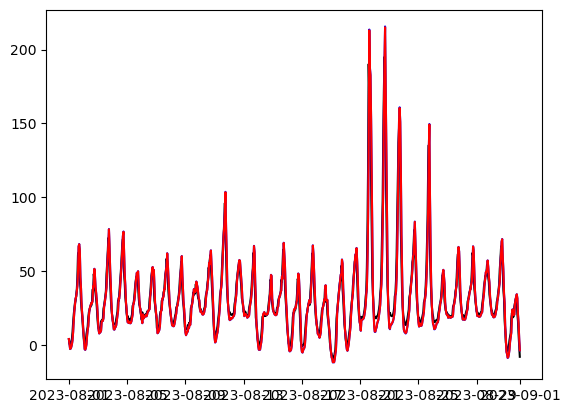

In [36]:
plt.figure()
plt.plot(cimarron.loc["2023-08"], color = "black")
plt.plot(Hfit1.fittedvalues.loc["2023-08"], color="blue")
plt.plot(Hfit2.fittedvalues.loc["2023-08"], color="red")

### Seasonally Adjusted Data